## 0.Préambule

### Mot introductif

Ce projet de Machine Learning se concentre sur la création d'un système de recommandation de films, s'inspirant d'un article mettant en avant l'utilisation du Cosine Similarity dans les recommandations. Guidé par la passion pour le cinéma et motivé par la découverte de cette mesure de similarité, **notre objectif est de développer un système plus ou moins précis et personnalisé pour recommander des films en se basant sur les caractéristiques d'un film donné.** On s'est basé sur l'article [suivant.](https://naomy-gomes.medium.com/the-cosine-similarity-and-its-use-in-recommendation-systems-cb2ebd811ce1)

 Après avoir récupéré les données via l'API TMDB, des analyses statistiques descriptives ont été effectuées pour comprendre la nature des données. En parallèle, un modèle de recommandation de films a été créé. Pour rendre l'expérience plus interactive, une application visuelle a été développée en utilisant la bibliothèque DASH, offrant une interface conviviale pour explorer les recommandations de films et interagir avec le système de recommandation.

### Importation des modules et packages

#### Pour les requêtes API et exporter les données

In [1]:
# Pour la requête API
import requests
#Pour exporter en json
import json 
#Pour lire et manipuler les DataFrame
import pandas as pd
#Pour exporter et lire des objets (ex : liste/  dictionnaire)
import pickle

#### Visualisation et analyse des données

In [2]:
# Lecture et traitement du dataframe
import pandas as pd 
import numpy as np 
import pickle

# Visualisation et analyse graphique des données
import matplotlib.pyplot as plt
import seaborn as sns 

# Visualisation et analyse cartographique des données
import geopandas as gpd

#### Modélisation

In [3]:
#transformation des mots en leur forme racine
from nltk.stem.porter import PorterStemmer
#conversion de texte en une matrice
from sklearn.feature_extraction.text import CountVectorizer
#Modèle que l'on va utiliser
from sklearn.metrics.pairwise import cosine_similarity

### I. Récupération des données

#### a. Code de la requête

Nous avons utilisé l'API TMDB pour récupérer 10000 films même si après nettoyage de la base de donnée nous en aurons moins.

On commence par récupérer les `id` des films *popular*, puis on effectue des requêtes pour avoir les détails de tous ses films. 

À la fin des requêtes, on exporte le fichier en JSON. Le fichier fait 1/2Go, ce qui s'explique notamment par la quantité de texte importante dans le dataframe.

La documentation de l'API est [ici.](https://developer.themoviedb.org/reference/intro/getting-started)

In [ ]:
#clé d'API TMDb
api_key = '28c6630049f5d468217e4f34963c03a6'

# URL de base de l'API TMDb pour les films populaires
base_url_popular = 'https://api.themoviedb.org/3/movie/popular'

# Nombre total de films à récupérer. Sur le forum TMDB, on voit que c'est le nombre maximal de films.
total_movies = 10000

# Nombre de films à récupérer par requête : il y a 20 films par page
movies_per_request = 20

# On récupère juste les id des films
fields = 'id' 

# Liste pour stocker tous les films avec leurs détails
all_movies_details = []

# Nombre de requêtes nécessaires pour obtenir le nombre total de films
num_requests = total_movies // movies_per_request

# On effectue les requêtes pour récupérer les films populaires
for page in range(1, num_requests + 1):
    params = {
        'api_key': api_key,
        'page': page,
        'fields': fields
    }
    response = requests.get(base_url_popular, params=params)

    if response.status_code == 200:
        movies_data = response.json()
        movies_reco = movies_data.get('results', [])

            # Pour chaque film, on récupère les détails supplémentaires
        for movie in movies_reco:
            movie_id = movie['id']
            movie_details_url = f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}&append_to_response=credits,keywords'
            movie_details_response = requests.get(movie_details_url)
            if movie_details_response.status_code == 200:
                movie_details = movie_details_response.json()
                all_movies_details.append(movie_details)
                print(f"Film {movie['title']} récupéré avec détails supplémentaires.")
            else:
                print(f"Erreur lors de la récupération des détails pour {movie['title']}. Statut : {movie_details_response.status_code}")
        print(f"Page {page} récupérée. Total de films récupérés : {len(all_movies_details)}")

    else:
        print(f"Erreur lors de la requête pour la page {page}. Statut : {response.status_code}")


    if len(all_movies_details) >= total_movies:
        break

# On enregistre les données complètes dans un fichier JSON
with open('movies_data_complete.json', 'w', encoding='utf-8') as f:
    json.dump(all_movies_details, f, ensure_ascii=False, indent=4)

print("Récupération des films avec détails complets terminée. Les données ont été enregistrées dans movies_data_complete.json.")

#### b. Affichage du DataFrame

On utilise le fichier Json qu'on a exporté pour éviter de faire la requête API à nouveau. 

**Attention :** Si vous lancez le code pour tester sur un nombre de films moins grand de renommer le fichier de sortie pour pas modifier la base entière.

In [9]:
movies_data=pd.read_json('movies_data_complete.json')
movies_data.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits,keywords
0,False,/1X7vow16X7CnCoexXh4H4F2yDJv.jpg,None,200000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",https://www.killersoftheflowermoonmovie.com,466420,tt5537002,en,Killers of the Flower Moon,...,206,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Greed is an animal that hungers for blood.,Killers of the Flower Moon,False,7.622,1479,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1157, 'name': 'husband wi..."
1,False,/zIYROrkHJPYB3VTiW1L9QVgaQO.jpg,None,40000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://freelance.movie,897087,tt15744298,en,Freelance,...,108,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Retirement didn't suit him.,Freelance,False,6.539,322,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 6285, 'name': 'coup d'eta..."
2,False,/r1eCvALF6fN7anVYL8Zn7PaceD1.jpg,None,125000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",https://www.wonkamovie.com,787699,tt6166392,en,Wonka,...,117,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Every good thing in this world started with a ...,Wonka,False,7.271,316,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 715, 'name': 'chocolate'}..."
3,False,/k1KrbaCMACQiq7EA0Yhw3bdzMv7.jpg,"{'id': 489724, 'name': 'The Trolls Collection'...",95000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",https://www.delfi.lt,901362,tt14362112,en,Trolls Band Together,...,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There are some new trolls on the block.,Trolls Band Together,False,7.172,379,"{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 3490, 'name': 'pop star'}..."
4,False,/9PqD3wSIjntyJDBzMNuxuKHwpUD.jpg,None,0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",https://www.netflix.com/title/81218917,1075794,tt5755238,en,Leo,...,102,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Breaking out this November.,Leo,False,7.609,597,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1517, 'name': 'classroom'..."


Quelques informations sur la base de données :

In [10]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  10000 non-null  bool   
 1   backdrop_path          9922 non-null   object 
 2   belongs_to_collection  2578 non-null   object 
 3   budget                 10000 non-null  int64  
 4   genres                 10000 non-null  object 
 5   homepage               10000 non-null  object 
 6   id                     10000 non-null  int64  
 7   imdb_id                9958 non-null   object 
 8   original_language      10000 non-null  object 
 9   original_title         10000 non-null  object 
 10  overview               10000 non-null  object 
 11  popularity             10000 non-null  float64
 12  poster_path            9996 non-null   object 
 13  production_companies   10000 non-null  object 
 14  production_countries   10000 non-null  object 
 15  rel

### II. Nettoyage des données

#### II.1. Choix des variables utiles

Tout d'abord, on récupère les données qui nous seront utiles dans la création de l'application, aussi pour le modèle, et on supprime les films doublons, qui ne sont pas encore sorti (ex : *Avatar 3*) et ceux dont le `runtime` est nul.

On ne garde que les films qui sont sortis et dont le revenu et le runtime sont strictement positifs. 

In [11]:
selected_columns=['id','title','original_title','overview','release_date','adult','popularity','vote_average','vote_count','poster_path','runtime','genres','production_companies','production_countries','spoken_languages','credits','keywords','status']
movies_data=movies_data[selected_columns]
movies_data= movies_data.drop_duplicates(subset='title', keep='first')
movies_data=movies_data[movies_data.status=='Released']
movies_data= movies_data[movies_data.runtime!=0]

Enfin, on ne conserve que l'année de sortie du film uniquement pour le developpement de l'application.

In [12]:
#On change le type de la colonne release_date
movies_data.release_date=pd.to_datetime(movies_data.release_date, format='%Y-%m-%d', errors = 'ignore')
#On garde quel'année
movies_data['release_year']=movies_data['release_date'].dt.year 
#On supprimme les colonnes qui ne sont plus utile
movies_data.drop(['release_date','status'],axis=1,inplace=True)
#On reset l'index car on a supprimé des lignes
movies_data=movies_data.reset_index(drop=True)

####  II.2. Résolution des problèmes du dataset

On travaille à présent sur les différentes colonnes où les données ne sont pas directement exploitables comme `genres`, `production_companies`, `production_countries`, `spoken_languages`. On ne conserve que les informations importantes : dans chaque dictionnaire, on conserve les valeurs de *name*. 

In [7]:
movies_data.loc[0].genres

[{'id': 80, 'name': 'Crime'},
 {'id': 18, 'name': 'Drama'},
 {'id': 36, 'name': 'History'}]

On crée une fonction pour directement extraire les données importanes de *genres, production_countries, spoken_languages & production_companies*. On voit que l'on doit toujours récupérer la valeur de la clé `name` d'où la création de la fonction **convert**.

In [13]:
def convert(text):
    L = []
    for i in text:
        L.append(i["name"]) 
    return L 
movies_data['genres'] = movies_data['genres'].apply(convert)
#On fait le choix de garder que le pays de production majoritaire d'où la fonction .apply
movies_data['production_countries'] = movies_data['production_countries'].apply(convert).apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
movies_data['spoken_languages']=movies_data['spoken_languages'].apply(convert)
#On fait le choix de garder que la société de production majoritaire d'où la fonction .apply
movies_data['production_companies']=(movies_data['production_companies'].apply(convert)).apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
#On garde que la principale entreprise de production.
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,credits,keywords,release_year
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,United States of America,"[English, Français, Latin]","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1157, 'name': 'husband wi...",2023
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,United States of America,"[English, Español]","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 6285, 'name': 'coup d'eta...",2023
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,United Kingdom,[English],"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 715, 'name': 'chocolate'}...",2023
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,United States of America,"[English, Lietuvių]","{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 3490, 'name': 'pop star'}...",2023
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,Australia,[English],"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1517, 'name': 'classroom'...",2023


On gère la colonnes *keywords* de la même manière sauf qu'il existe des films sans mots clés. On supprime ces films car cette colonne est très importante pour le modèle que l'on va créer.
Regarder les keywords *Robot Apocalypse*  : {'keywords':[]}

In [14]:
movies_data['keywords'] = movies_data['keywords'].apply(lambda x: x['keywords'] if isinstance(x, dict) and 'keywords' in x else None) # On récupère les listes des mots clés.
movies_data = movies_data[movies_data['keywords'].apply(lambda x: isinstance(x, list) and len(x) > 0)] # on supprime les films où la liste est vide comme pour Robot Apocalypse.
movies_data["keywords"]=movies_data["keywords"].apply(convert) 
#On supprime des lignes, on fait donc un reset_index
movies_data.reset_index(drop=True,inplace=True)

Enfin, on sépare les *credits* entre le *cast* et le *crew*, où respectivement on récupère les trois acteurs principaux et le réalisateur.

In [15]:
#On sépare le cast et le crew
movies_data['cast'] = movies_data['credits'].apply(lambda x: x.get('cast') if isinstance(x, dict) else None)
movies_data['crew'] = movies_data['credits'].apply(lambda x: x.get('crew') if isinstance(x, dict) else None)
#On supprime la colonne crédits
movies_data.drop("credits", axis=1, inplace=True)
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,keywords,release_year,cast,crew
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,United States of America,"[English, Français, Latin]","[husband wife relationship, based on novel or ...",2023,"[{'adult': False, 'gender': 2, 'id': 6193, 'kn...","[{'adult': False, 'gender': 2, 'id': 27, 'know..."
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,United States of America,"[English, Español]","[coup d'etat, dictatorship, political assassin...",2023,"[{'adult': False, 'gender': 2, 'id': 56446, 'k...","[{'adult': True, 'gender': 2, 'id': 997, 'know..."
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,United Kingdom,[English],"[chocolate, musical, prequel]",2023,"[{'adult': False, 'gender': 2, 'id': 1190668, ...","[{'adult': False, 'gender': 2, 'id': 1299, 'kn..."
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,United States of America,"[English, Lietuvių]","[pop star, brother, musical, sequel, based on ...",2023,"[{'adult': False, 'gender': 1, 'id': 84223, 'k...","[{'adult': False, 'gender': 2, 'id': 10572, 'k..."
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,Australia,[English],"[classroom, musical, bucket list]",2023,"[{'adult': False, 'gender': 2, 'id': 19292, 'k...","[{'adult': False, 'gender': 0, 'id': 7963, 'kn..."


Création de la fonction récupérant les trois acteurs principaux et de la fonction récupérant le réalisateur.

In [16]:
#Cette fonction récupère les trois acteurs principaux de la colonne cast
def convert3(text):
    L = []
    counter = 0
    for i in text:
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L 
#Cette fonction parcourt le crew jusqu'à atteindre le director
def fetch_director(text):
    L = []
    for i in text:
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    return L 
movies_data["cast"]=movies_data["cast"].apply(convert3) # Ils sont rangés par importance dans la colonne
movies_data["crew"]=movies_data["crew"].apply(fetch_director)
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,keywords,release_year,cast,crew
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,United States of America,"[English, Français, Latin]","[husband wife relationship, based on novel or ...",2023,"[Leonardo DiCaprio, Lily Gladstone, Robert De ...",[Martin Scorsese]
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,United States of America,"[English, Español]","[coup d'etat, dictatorship, political assassin...",2023,"[John Cena, Alison Brie, Juan Pablo Raba]",[Pierre Morel]
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,United Kingdom,[English],"[chocolate, musical, prequel]",2023,"[Timothée Chalamet, Calah Lane, Keegan-Michael...",[Paul King]
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,United States of America,"[English, Lietuvių]","[pop star, brother, musical, sequel, based on ...",2023,"[Anna Kendrick, Justin Timberlake, Camila Cabe...",[Walt Dohrn]
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,Australia,[English],"[classroom, musical, bucket list]",2023,"[Adam Sandler, Bill Burr, Cecily Strong]",[Robert Smigel]


In [12]:
movies_data.shape

(8292, 18)

**Conclusion :** Après nettoyage, on a donc 8292 films.

### III. Visualisation des données

#### III.1. Analyse de la répartition des données : description du dataset

Visualisons tout d'abord nos données brutes pour comprendre la répartition des films sélectionnés selon un certain nombre de critères.

##### III.1.1. Répartition dans le temps

On donne la répartition dans le temps (tous les 5 ans) de la création de films 

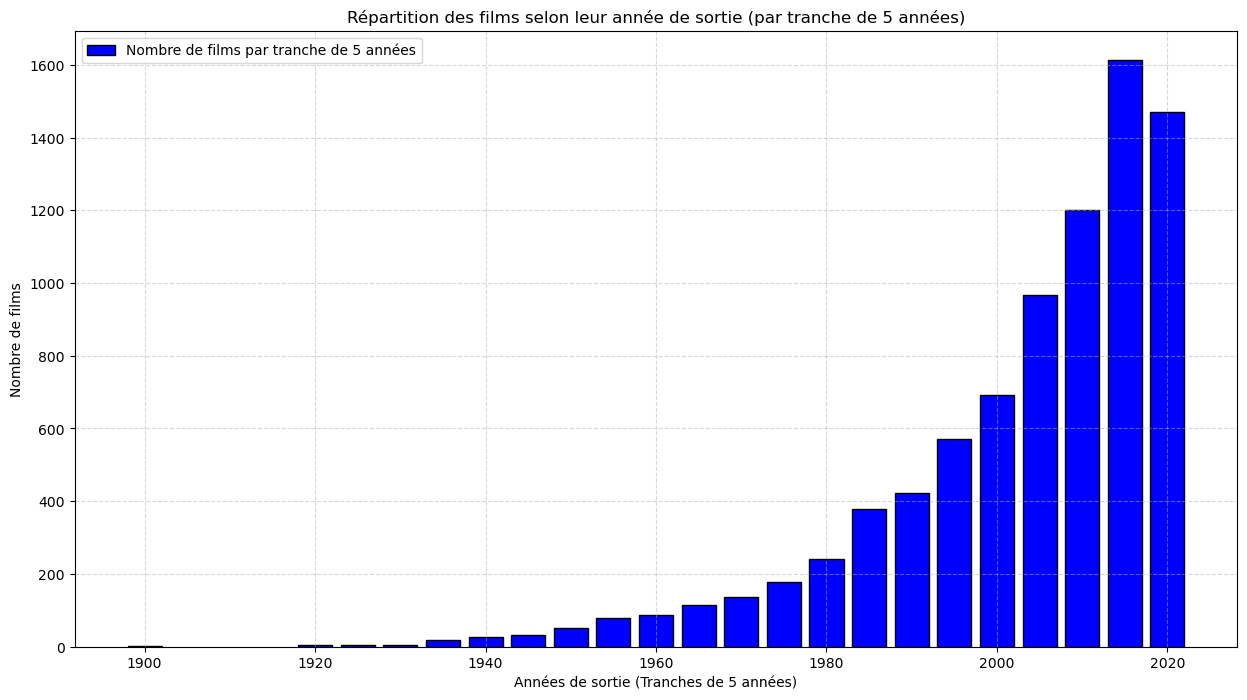

In [20]:
releases = {}
for year in movies_data['release_year']:
    if str(year) not in releases:
        releases[str(year)] = 0
    releases[str(year)] +=1

releases = {k:v for k, v in sorted(releases.items())}

# On crée d'un nouveau dictionnaire pour regrouper les années par tranche de 5 ans
grouped_releases = {}

# On regroupe des années par tranche de 5 ans et calcul du nombre de films publiés dans chaque tranche
for year, count in releases.items():
    interval = (int(year) // 5) * 5  # Calcul de l'intervalle de 5 ans
    if interval not in grouped_releases:
        grouped_releases[interval] = 0
    grouped_releases[interval] += count

fig = plt.figure(figsize=(15, 8))
plt.bar(grouped_releases.keys(), grouped_releases.values(), width=4, align='center', 
        label="Nombre de films par tranche de 5 années", color='blue', edgecolor='black')
plt.xlabel("Années de sortie (Tranches de 5 années)")
plt.ylabel("Nombre de films")
plt.title("Répartition des films selon leur année de sortie (par tranche de 5 années)")
plt.legend()
plt.grid(linestyle='dashed', alpha=0.5)
plt.show()


On observe que le nombre de film dans notre dataset est croissant du temps. Entre les annnées 2010 et 2020, la production des films était à son maximum,avec plus de 1600 films produits pendant cette période.
On constate une baisse en 2020 qui peut s'expliquer par le confinement du au Covid.




##### III.1.2. Répartition des films par genres et par pays de production

Comme chaque film a plusieurs `genres`, on les compte tous dans chaque catégorie.

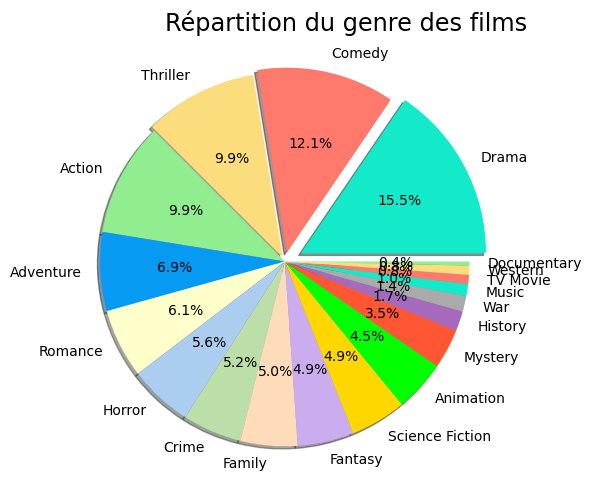

In [14]:
genre_count_dict = {}

# On parcourt les listes de genres pour chaque film et compter le nombre de films pour chaque genre
for genres_list in movies_data['genres']:
    for genre in genres_list:
        if genre in genre_count_dict:
            genre_count_dict[genre] += 1
        else:
            genre_count_dict[genre] = 1

Autres=["History","Music","War", "TV Movie","Western","Documentary"]

# On convertit le dictionnaire en DataFrame pour obtenir le décompte du nombre de films par genre
genre_counts = pd.DataFrame(list(genre_count_dict.items()), columns=['Genre', 'Count'])
genre_counts = genre_counts.sort_values(by='Count', ascending=False)

# On utilise les décomptes réels à partir de 'genre_counts'
Liste = genre_counts['Count'].tolist()  # On utilise les décomptes pour les 16 premiers genres
Labels = genre_counts['Genre'].tolist() # On utilise les noms des 16 premiers genres
myexplode = [0.2,0.1,0.05]+[0] * 16  # On explose pour la première tranche, pas d'explosion pour les autres
colors = ['#13EAC9', '#FF796C', '#FBDD7E', '#90EE90', '#069AF3', '#FFFFCB', '#ABCDEF', '#BCDFAA', '#FEDCBA', '#CBADEF', '#FFD700', '#00FF00', '#FF5733', '#A569BD', '#AAAAAA']

# On crée du pie chart avec les données de décompte réelles
plt.figure(figsize=(5, 3))
plt.pie(Liste, labels=Labels, explode=myexplode, colors=colors, autopct='%1.1f%%', startangle=0, shadow=True, radius=2)
plt.text(-1.3, 2.5, "Répartition du genre des films", fontsize='xx-large')
plt.show()



La réparition des genres est équilibré : il y a 15.5% de films "Drama", c'est le genre le plus représenté. Pour le reste, chaque genre est représenté entre environ 5% et 10%.

On donne la production de films par **pays** en ne gardant que le top 10 par soucis de lisibilité.

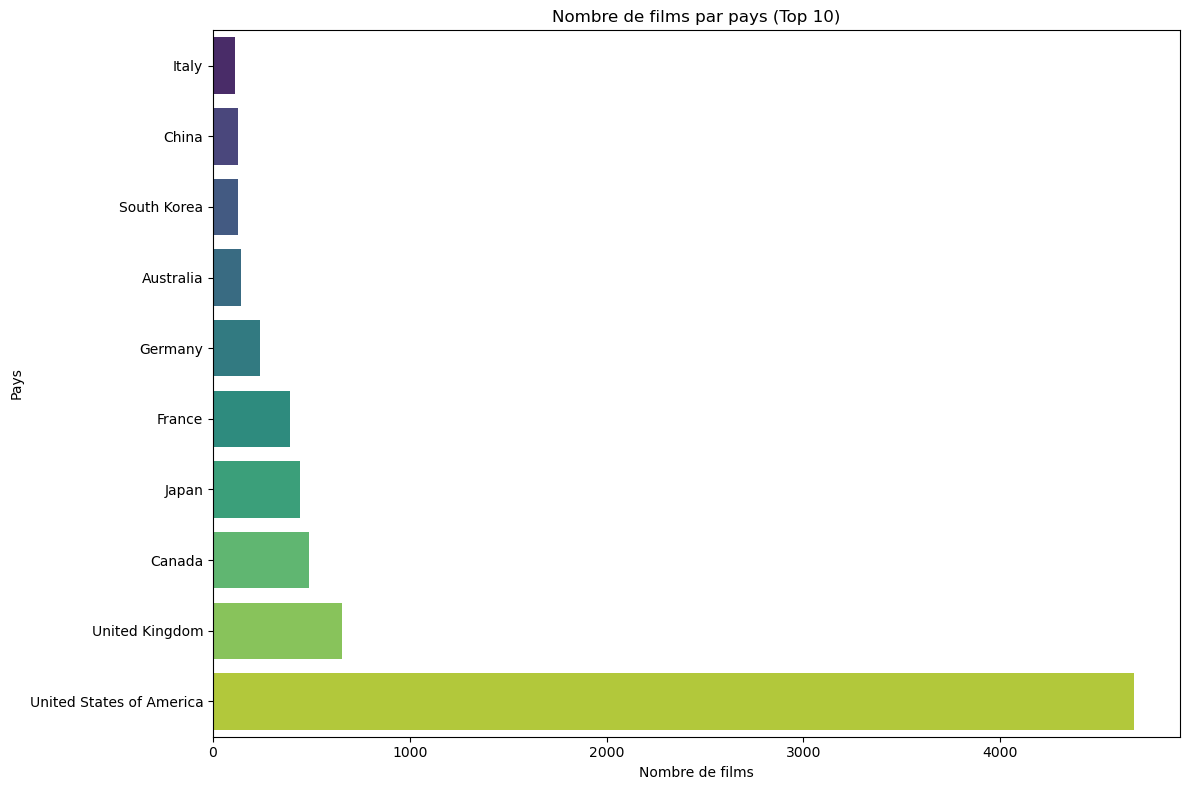

In [26]:
# On compte le nombre de films par pays
films_par_pays = movies_data['production_countries'].value_counts().reset_index()
films_par_pays.columns = ['Pays', 'Nombre de films']
films_par_pays = films_par_pays.sort_values('Nombre de films', ascending=True)

# On garde uniquement les 10 premiers pays pour l'affichage
top_countries_to_keep = 10
plt.figure(figsize=(12, 8))
sns.barplot(x='Nombre de films', y='Pays', data=films_par_pays.tail(top_countries_to_keep), palette='viridis')
plt.xlabel('Nombre de films')
plt.ylabel('Pays')
plt.title('Nombre de films par pays (Top 10)')
plt.tight_layout()
plt.show()


Les États-Unis ont sans surprise le monopole sur la création des films dans la base de données avec plus de 4000 films américains, suivi par le Royaume-Uni avec 700 films et la France avec 500 films. La production américains de films dépasse la somme des productions des 9 autres pays les plus producteurs ensemble.


#### III.2 Les réalisateurs et les entreprises de productions les plus représentées.

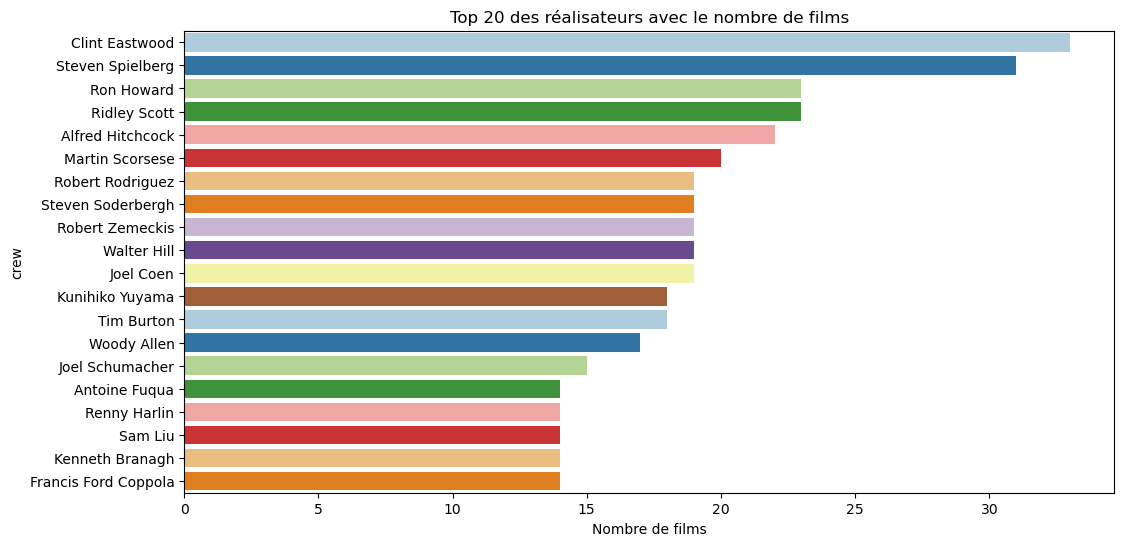

In [21]:
# On convertit la colonne 'crew' en une série pandas pour faciliter le traitement
directors = movies_data['crew'].explode()

# On crée un countplot pour les 20 réalisateurs les plus fréquents
plt.figure(figsize=(12, 6))
sns.countplot(y=directors, palette='Paired',
              order=directors.value_counts().index[:20])
plt.title("Top 20 des réalisateurs avec le nombre de films")
plt.xlabel("Nombre de films")
plt.show()

Les 10 premiers réalisateurs ont réalisé plus de 20 films chacun comme Clint Eastwood, Steven Spielberg etc.

On fait la même chose pour les sociétés de productions


Text(0.5, 1.0, 'Top 20 production companies with number of movies released')

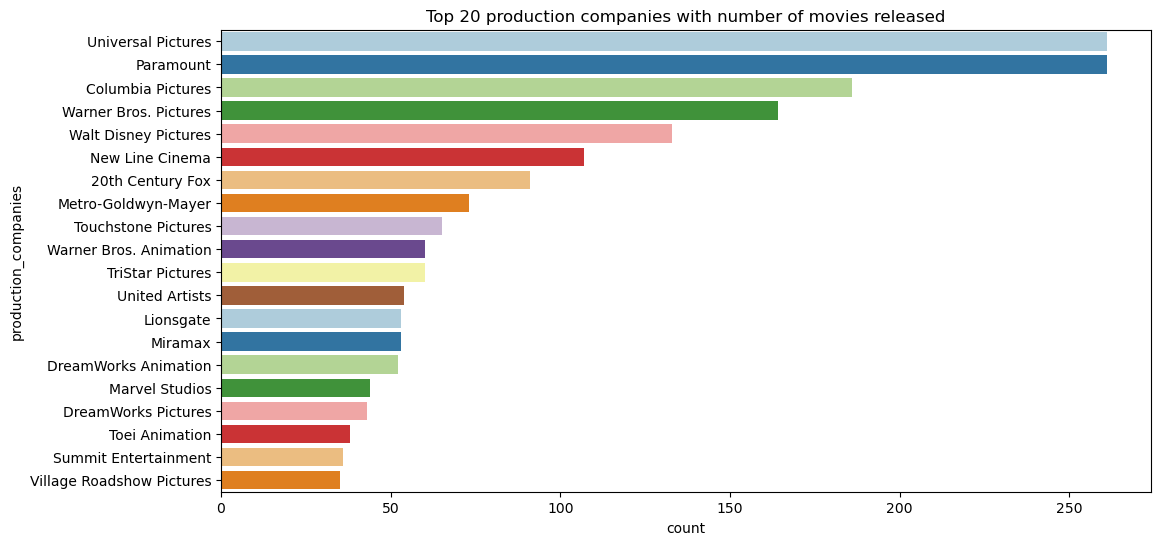

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(y="production_companies",palette = 'Paired', data=movies_data,order=movies_data['production_companies'].value_counts().index[0:20])
plt.title("Top 20 production companies with number of movies released")

Les deux sociétés Universal Pictures et Paramount ont la grande part du marché de production des films avec plus de 250 films produits chacune.

La plupart des sociétés de productions ont un volume de production moyen qui dépasse pas 100 films en général sauf les plus connus : Universal Pictures, Paramount, Columbia, Warner Bros et Walt Disney.

#### III.3 Les films les mieux notés par genre

On considère les films les mieux notés par genre :

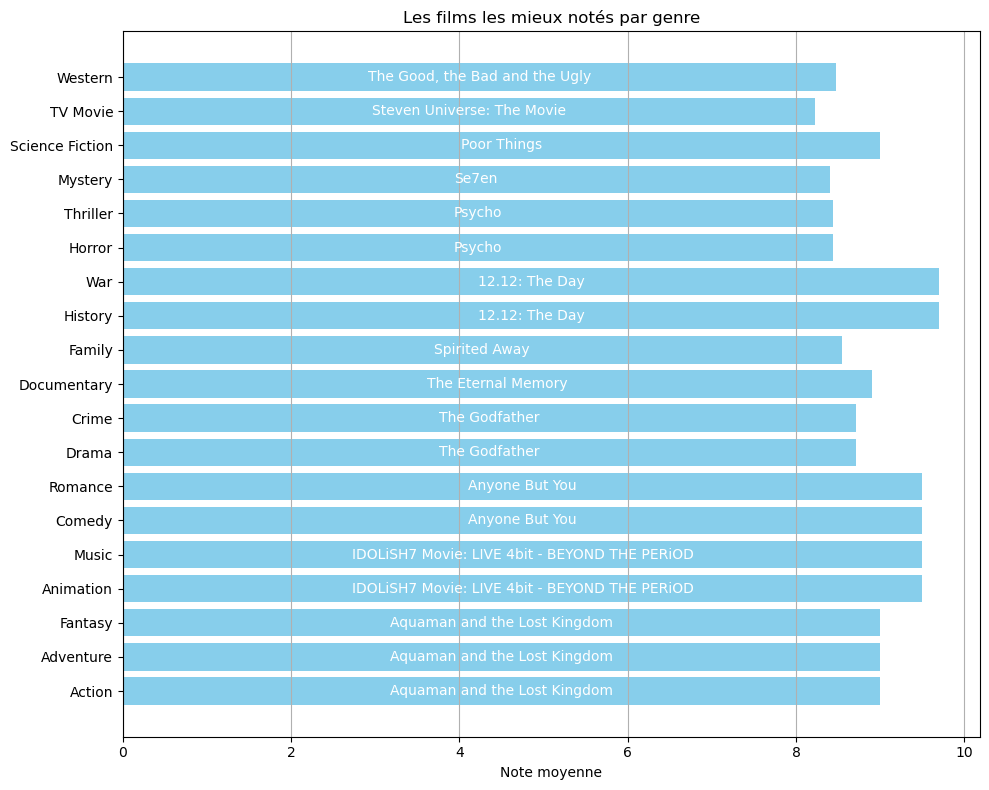

In [23]:
# On utilise explode pour déplier les listes de genres
movies_genre = movies_data.explode('genres')

# On groupe par 'genres' pour obtenir les indices des films les mieux notés pour chaque genre
best_rated_indices = movies_genre.groupby('genres')['vote_average'].idxmax()

# On récupére les détails des films les mieux notés pour chaque genre
best_rated_details = movies_genre.loc[best_rated_indices, ['genres', 'title', 'vote_average']].drop_duplicates("genres")

plt.figure(figsize=(10, 8))
bars = plt.barh(best_rated_details['genres'], best_rated_details['vote_average'], color='skyblue')
plt.xlabel('Note moyenne')
plt.title('Les films les mieux notés par genre')
plt.grid(axis='x')

# On ajoute des titres des films à l'intérieur de chaque barre
for bar, title in zip(bars, best_rated_details['title']):
    plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{title}', va='center', ha='center', color='white')

plt.tight_layout()
plt.show()



Des films apparaissent plusieurs fois car ils sont dans plusieurs genres. Les films sont tous au dessus de 8/10 avec *12:12 : The Day* avec une note à 9.75/10.

#### III. 3 Visualisation géographique : Note moyenne par pays

In [24]:
# On groupe les données par pays de production et calculer la note moyenne
average_ratings_by_country = movies_data.groupby('production_countries')['vote_average'].mean().reset_index()

# On affiche le DataFrame résultant avec la note moyenne par pays
average_ratings_by_country=pd.DataFrame(average_ratings_by_country)
average_ratings_by_country.head()

,production_countries,vote_average
0,Argentina,6.199412
1,Aruba,5.200000
2,Australia,6.437106
3,Austria,6.958143
4,Bahamas,5.913000


In [25]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['Country'] = world['name']
world = world[['geometry', 'Country']]

In [26]:
world_movies = pd.merge(world, average_ratings_by_country, how='left', left_on='Country', right_on='production_countries')
world_movies.head()

,geometry,Country,production_countries,vote_average
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,NaN,NaN
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,NaN,NaN
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",W. Sahara,NaN,NaN
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,Canada,6.226222
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,United States of America,6.491104


<Axes: >

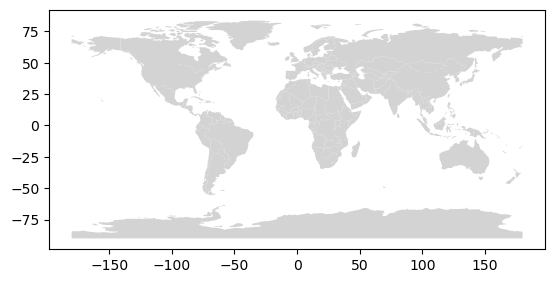

In [27]:
world_movies.plot(color='lightgrey')

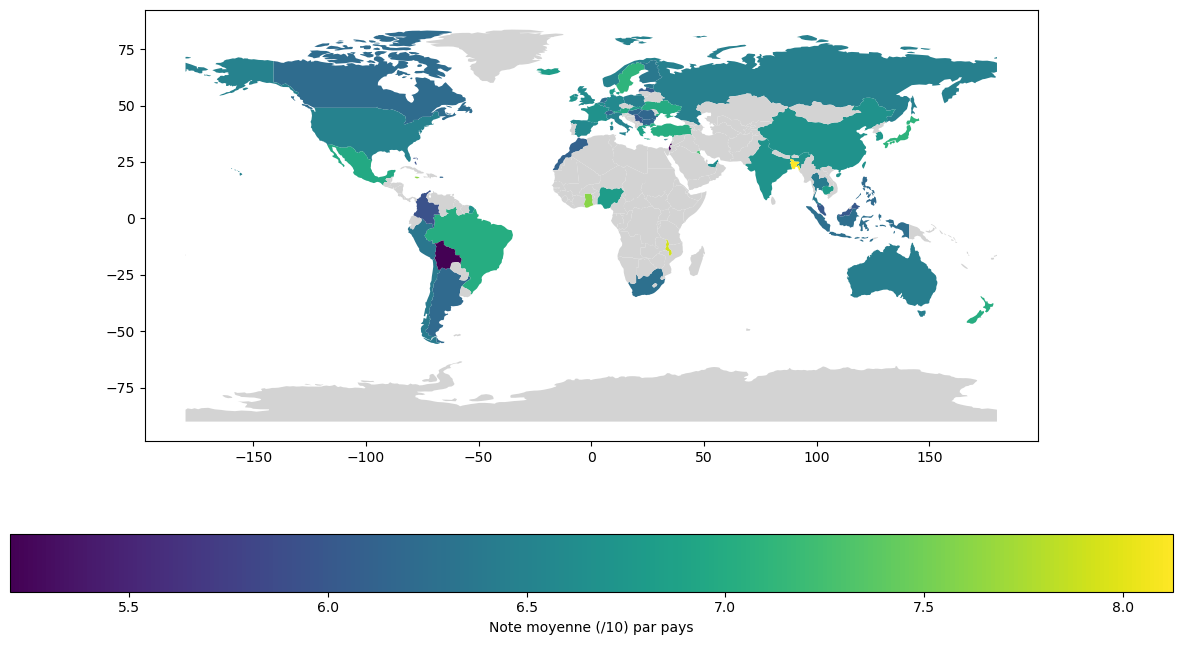

In [28]:
world_movies.plot(
    column="vote_average",
    legend=True,
    legend_kwds={'label': "Note moyenne (/10) par pays",
                        'orientation': "horizontal"},
    figsize=(15, 8),
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    },
);

L'ensemble des pays ont une note moyenne autour de 6.5/10 à l'exception du Bangladesh et le Malawi (en Afrique) dont leur note moyenne est autour de 8/10. Ceci peut s'expliquer par le faible nombre de films réalisés. Enfin, on a la Bolivie en dessous de la moyenne mondiale avec une note moyenne à 5.5/10.

### IV. Modélisation

#### IV.1 Préprocessing

On récupère les colonnes pertinentes pour comparer les films entre eux :

* `id`

* `title`
* `overview`
* `genres`
* `keywords`
* `cast`
* `crew`


In [29]:
movies_reco=movies_data[["id","title","overview","genres","keywords","cast","crew"]]
movies_reco.head()

,id,title,overview,genres,keywords,cast,crew
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,"[Crime, Drama, History]","[husband wife relationship, based on novel or ...","[Leonardo DiCaprio, Lily Gladstone, Robert De ...",[Martin Scorsese]
1,897087,Freelance,An ex-special forces operative takes a job to ...,"[Action, Comedy]","[coup d'etat, dictatorship, political assassin...","[John Cena, Alison Brie, Juan Pablo Raba]",[Pierre Morel]
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...,"[Comedy, Family, Fantasy]","[chocolate, musical, prequel]","[Timothée Chalamet, Calah Lane, Keegan-Michael...",[Paul King]
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...","[Animation, Family, Music, Fantasy, Comedy]","[pop star, brother, musical, sequel, based on ...","[Anna Kendrick, Justin Timberlake, Camila Cabe...",[Walt Dohrn]
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...,"[Animation, Comedy, Family]","[classroom, musical, bucket list]","[Adam Sandler, Bill Burr, Cecily Strong]",[Robert Smigel]


On enlève les espaces inutiles dans les colonnes ` cast`, `crew`, `genres` et `keywords` pour éviter des similarités entre des films où juste le prénom d'un acteur ou du réalisateur sont en commun.

In [30]:
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1
movies_reco['cast'] = movies_reco['cast'].apply(collapse)
movies_reco['crew'] = movies_reco['crew'].apply(collapse)
movies_reco['genres'] = movies_reco['genres'].apply(collapse)
movies_reco['keywords'] = movies_reco['keywords'].apply(collapse)

/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_697/813522039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['cast'] = movies_reco['cast'].apply(collapse)
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_697/813522039.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['crew'] = movies_reco['crew'].apply(collapse)
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_697/813522039.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,id,title,overview,genres,keywords,cast,crew
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,"[Crime, Drama, History]","[husbandwiferelationship, basedonnovelorbook, ...","[LeonardoDiCaprio, LilyGladstone, RobertDeNiro]",[MartinScorsese]
1,897087,Freelance,An ex-special forces operative takes a job to ...,"[Action, Comedy]","[coupd'etat, dictatorship, politicalassassinat...","[JohnCena, AlisonBrie, JuanPabloRaba]",[PierreMorel]
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...,"[Comedy, Family, Fantasy]","[chocolate, musical, prequel]","[TimothéeChalamet, CalahLane, Keegan-MichaelKey]",[PaulKing]
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...","[Animation, Family, Music, Fantasy, Comedy]","[popstar, brother, musical, sequel, basedontoy...","[AnnaKendrick, JustinTimberlake, CamilaCabello]",[WaltDohrn]
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...,"[Animation, Comedy, Family]","[classroom, musical, bucketlist]","[AdamSandler, BillBurr, CecilyStrong]",[RobertSmigel]


On crée une colonne `label` contenant les informations des colonnes/features conservées.

In [31]:
#On crée des listes pour les sommer (concaténer) plus facilement
movies_reco['overview'] = movies_reco['overview'].apply(lambda x:x.split())
#On crée cette colonne temporaire pour pouvoir le mettre dans le label
movies_reco["title_bis"]=movies_reco["title"].apply(lambda x:x.split())
movies_reco['label'] = movies_reco['overview']+movies_reco['title_bis']+movies_reco['genres'] + movies_reco['keywords'] + movies_reco['cast'] + movies_reco['crew']
data_model=movies_reco.drop(columns=['overview','genres','keywords','cast','crew',"title_bis"])
data_model['label'] = data_model['label'].apply(lambda x: " ".join(x))
data_model.head()

/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_697/2000391329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['overview'] = movies_reco['overview'].apply(lambda x:x.split())
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_697/2000391329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco["title_bis"]=movies_reco["title"].apply(lambda x:x.split())
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_697/2000391329.py:4: SettingWithCopyWarning: 
A value

,id,title,label
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...
1,897087,Freelance,An ex-special forces operative takes a job to ...
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for..."
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...


**Traitement de texte :** On applique la fonction `stem`, utilisant la bibliothèque NLTK (Natural Language Toolkit) pour le prétraitement des données textuelles, pour enlever les suffixes inutiles.
 
 Voici une explication simple étape par étape : 

 * Le code commence par l'importation du PorterStemmer, qui est un algorithme de stemming (racinisation) souvent utilisé pour réduire les mots à leur racine. 
 
 * La fonction stem(text) prend en entrée un texte et le traite pour réduire chaque mot à sa racine. Le stemming est un processus qui consiste à réduire les mots à leur forme de base ou racine, ce qui aide à regrouper différentes variantes d'un mot ensemble.

 * On met tout le texte en minuscule avec la méthode .lower()

In [32]:
ps =PorterStemmer()
def stem(text): # stem("dancing")=>"danc"
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)
data_model["label"]=data_model["label"].apply(stem)
data_model["label"]=data_model["label"].apply(lambda x : x.lower())
data_model.head()

,id,title,label
0,466420,Killers of the Flower Moon,when oil is discov in 1920 oklahoma under osag...
1,897087,Freelance,an ex-speci forc oper take a job to provid sec...
2,787699,Wonka,willi wonka – chock-ful of idea and determin t...
3,901362,Trolls Band Together,"when branch' brother, floyd, is kidnap for hi ..."
4,1075794,Leo,jade 74-year-old lizard leo ha been stuck in t...


Une instance de CountVectorizer est créée avec les paramètres suivants :
* **max_features=5000:** Cela spécifie le nombre maximum de mots dans ce contexte à extraire des textes. Seuls les 5000 mots les plus fréquents seront pris en compte.

* **stop_words='english':** Cette option indique à CountVectorizer d'utiliser les mots vides (stop words) en anglais. Les mots vides sont des mots courants qui sont souvent supprimés car ils ne portent pas beaucoup d'informations (par exemple, "the", "is", "and", etc.).

* **La méthode fit_transform()** est utilisée pour transformer les données textuelles de la colonne "label" du DataFrame data_model en une représentation numérique. Cela signifie que chaque texte est converti en un vecteur de nombres représentant la fréquence des mots dans ce texte.

On reviendra plus tard sur ce choix de vectorisation.

In [33]:
cv = CountVectorizer(max_features=5000,stop_words='english')
matrix = cv.fit_transform(data_model['label']).toarray()

#### IV.2 Le modèle de cosine similarity

La similarité cosinus (cosine similarity) est une mesure de similarité entre deux vecteurs dans l'espace vectoriel. En utilisant la bibliothèque sklearn, la fonction cosine_similarity est utilisée pour calculer la similarité cosinus entre les vecteurs. 

**Voici la formule mathématique de la similarité cosinus :** La formule de la similarité cosinus pour deux vecteurs $A$ et $B$ est donnée par :
<center>

$\text{CS}(\mathbf{A}, \mathbf{B}) = \frac{<\mathbf{A},\mathbf{B}>}{\|\mathbf{A}\| \cdot \|\mathbf{B}\|}$

</center>

avec $<,>$ le produit scalaire usuelle dans $R^{d}$ et $\|\mathbf{X}\|$ le norme de $X$. C'est la généralisation du cosinus en dimension $d\geq2$.
<center>

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*dyH20eCqb6qTL-gt4nCVzQ.png" width="700" />
</center>

<center>

**Fig :** Principe du cosine simalarity
</center>


On crée donc la matrice de similarity ($S$) :

- on a donc $S_{i,j}=CS(M_{i},M_{j})$ avec $M_{k}$ le label vectorisé du $k$-ème films. À remarquer que la diagonale ne contient que des 1.

In [34]:
similarity = cosine_similarity(matrix)
similarity

array([[1.        , 0.        , 0.        , ..., 0.01690309, 0.06172134,
        0.        ],
       [0.        , 1.        , 0.03774257, ..., 0.09200874, 0.        ,
        0.03513642],
       [0.        , 0.03774257, 1.        , ..., 0.02344036, 0.0855921 ,
        0.10741723],
       ...,
       [0.01690309, 0.09200874, 0.02344036, ..., 1.        , 0.02608203,
        0.04364358],
       [0.06172134, 0.        , 0.0855921 , ..., 0.02608203, 1.        ,
        0.        ],
       [0.        , 0.03513642, 0.10741723, ..., 0.04364358, 0.        ,
        1.        ]])

In [35]:
similarity[similarity<0]

array([], dtype=float64)

On remarque qu'il y a aucune valeur négative.

On fait un changement d'échelle sur la matrice de similarité. C'est juste pour lisser les scores de recommandations dans l'application, c'est purement superficiel.

In [36]:
# Appliquer la fonction ln(2+x) sur chaque ligne de la matrice
similarity = np.log(1+similarity)
for i in range(len(similarity)):
    # Calculer le maximum de la ligne
    max_ligne = np.max(similarity[i])
    
    # Diviser chaque élément de la ligne par le maximum (sauf pour la diagonale)
    for j in range(len(similarity)):
        similarity[i][j] = similarity[i][j] / max_ligne

similarity

array([[1.        , 0.        , 0.        , ..., 0.02418219, 0.08640517,
        0.        ],
       [0.        , 1.        , 0.0534486 , ..., 0.1269844 , 0.        ,
        0.04982091],
       [0.        , 0.0534486 , 1.        , ..., 0.03342704, 0.11848213,
        0.14719888],
       ...,
       [0.02418219, 0.1269844 , 0.03342704, ..., 1.        , 0.03714607,
        0.06162909],
       [0.08640517, 0.        , 0.11848213, ..., 0.03714607, 1.        ,
        0.        ],
       [0.        , 0.04982091, 0.14719888, ..., 0.06162909, 0.        ,
        1.        ]])

Enfin, on définit la fonction `recommend` qui prend en argument le nom du film que l'on souhaite et le nombre de films que l'on veut en sortie :
* **On récupère l'index du film dans le DataFrame :** La fonction prend le nom d'un film en entrée et trouve son indice dans le DataFrame data_model.

* **On a accès aux similarités :** on a la similarité entre ce film et tous les autres films à l'aide de la matrice de similarité préalablement générée (similarity). Ces similarités sont triées par ordre décroissant afin de trouver les films les plus similaires.
* **Afficher les films recommandés :** on affiche les titres des films recommandés en fonction de leur similarité avec le film donné.

In [37]:
def recommend(movie,m):
    index = data_model[data_model['title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:m+1]:
        print(data_model.iloc[i[0]].title)

In [38]:
recommend("Iron Man",5)

Iron Man 3
Iron Man 2
The Invincible Iron Man
Avengers: Age of Ultron
Spider-Man: Homecoming


On récupère la matrice de similarité ci-dessous ainsi, que la base `movies_data` via la librairie `pickle`.

In [39]:
pickle.dump(movies_data.to_dict(),open("movies_details.pkl","wb"))
pickle.dump(similarity,open("similarity.pkl","wb"))

Ainsi, se conclut la partie programmation du modèle, mais une étape a été laisser de côté. On s'est rendu compte durant les tests de l'application que la méthode de vectorisation est finalement importante, car elle donne des résultats importantes.

### V. Evaluation du modèle

Les deux manières de vectoriser la colonne `label` avec scikit-learn sont :

+ **CountVectorizer :**  Il transforme le texte en une matrice où chaque ligne correspond à un label et chaque colonne correspond à un mot du vocabulaire, et les cellules contiennent le compte du nombre d'occurrences de chaque mot dans chaque document.

+ **TfidfVectorizer :** TfidfVectorizer calcule le score TF-IDF (Term Frequency-Inverse Document Frequency) pour chaque terme dans le corpus de label. Le score TF-IDF est une mesure statistique utilisée pour évaluer l'importance d'un terme dans un label par rapport aux autres label. Il pondère la fréquence d'un terme par son importance dans l'ensemble du corpus, en diminuant la pondération des mots fréquents et en augmentant la pondération des mots rares mais informatifs.

On pourrait épiloguer longtemps pour défendre une des méthodes de vectorisation mais la meilleure manière de les comparer c'est d'avoir une mesure entre les deux modèles.

On définit Top-5 Precision = $\frac{Nombre\ de\ films\ pertinents\ recommandés}{5}$. 

Il suffit de faire la moyenne ensuite sur l'ensemble du modèle ie :

Precision = $\frac{1}{N} \sum_{i=1}^{N} \frac{Nombre\ de\ films\ pertinents\ recommandés\ pour\ i}{5}$.

La pertinence serait défini finalement par l'utilisateur qui juge si les recommandations sont pertinentes vis à vis du film initialement recherché. Ainsi, il faudrait déployer l'application avec la possibilité de récupérer les avis des utilisateurs sur les films recommandés.

On laisse par défaut et de manière arbitraire **CountVectorizer** ne pouvant pas mesurer la pertinence rapidement dans le cadre du projet. 

On donne ci-dessous, les recommandations de certains films qu'on ne juge pas pertinent dans le cas des deux vectorisations :

In [40]:
recommend("Sound of Freedom",5)

Chaplin
Pain and Glory
22 Bullets
Robin-B-Hood
The Truman Show


*Sound of Freedom* est un film dramatique sur un kidnapping alors que *The Truman Show* est un film d'humour ...

In [41]:
recommend("The SpongeBob Movie: Sponge on the Run",5)

The SpongeBob SquarePants Movie
The Peanuts Movie
The Star
The Addams Family 2
Ciao Alberto


Dans ce cas là, pour *The SpongeBob Movie: Sponge on the Run*, les recommandations semblent pertinentes car ce sont que des dessins animés qui sont recommandés.
Passons avec l'autre manière de vectorisation **TfidfVectorizer**:

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
matrixbis = tfidf.fit_transform(data_model['label']).toarray()
similaritybis = cosine_similarity(matrixbis)
def recommendbis(movie,m):
    index = data_model[data_model['title'] == movie].index[0]
    distances = sorted(list(enumerate(similaritybis[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:m+1]:
        print(data_model.iloc[i[0]].title)
recommendbis("The SpongeBob Movie: Sponge on the Run",5)

The SpongeBob SquarePants Movie
The Secret Gift of Christmas
The Peanuts Movie
The Accidental Husband
The SpongeBob Movie: Sponge Out of Water


On perd de la pertinence ici car on nous recommande des TV movie, mais on en gagne effectivement pour d'autres films notamment ci-dessous.

In [43]:
recommendbis("Sound of Freedom",5)

The City of Lost Children
3096 Days
Mother's Day
Sex and Death 101
Darc


#### VI. Conclusion

Tout au long de ce projet, nous avons cherché à fournir des recommandations de films à partir d'un film donnée en fonction des caractéristiques, qu'on jugeait 

pertinente. De plus, ce projet a été pour nous l'occasion de réaliser un projet data de A à Z. En effet, au cours de ce projet, nous avons pu travailler, étudier et

les différents aspects de la DataScience et être confronté à toutes ses difficultés, notamment la récupération des données. Comme annoncé ci-dessus, pour le modèle 
 
présenté, il faudrait l'evaluer en ayant la pertinence des recommantions auprès d'utilisateurs mais néanmoins, le modèle reste satisfaisant dans l'ensemble. 

Ce projet a été une opportunité d'explorer l'utilisation de Dash. Bien que cela n'ait pas été requis dans le cadre du cours, nous avons trouvé intéressant d'aller au-delà d'une simple fonctionnalité `recommend` en créant une interface interactive. Cette approche visait à rendre l'expérience plus visuelle et conviviale pour les utilisateurs, leur permettant d'interagir avec le système de recommandation de manière plus intuitive et attrayante.

### VII. Application 

On expose quelques explications de l'application. La librairie Dash permet la création d'applications web interactives en utilisant Python, avec la possibilité de créer des visualisations de données interactives et des tableaux de bord personnalisés pour présenter et explorer leurs données de manière dynamique. Nous ne sommes surement pas aller dans les retranchements de Dash ce qui explique que l'application puisse ressembler à un ancien site des années 2000...

Je vous invite à aller voir le fichier `movie_recommender_app.py` et executer le code pour pouvoir lancer l'application `Dash` en local. 

**Explications du code :** On importe similarity.pkl et movies_details.pkl. On crée à nouveau la fonction `recommend` mais cette fois ci, elle donne aussi les chemins des affiches de films. La fonction `extract` est créée pour afficher les genres en chaines de caractères directement.

Ainsi, après cela débute le code de l'application. Deux barres de recherches sont disponibles : 
+ **Recherche de films** : on tape le nom du film que l'on veut
+ **filtre sur le genre** : au vue des quelques incohérences dans les recommandations, on a jugé interessant de pouvoir filtrer sur le genre.

$\rightarrow$ Par défaut, on affiche les films les plus populaires du moment avec leur note. On peut les filtrer par genre.

$\rightarrow$ Lorsqu'on effectue une recherche d'un film, l'affiche du film apparait avec les informations liées, ainsi que les films recommandés avec la note et le % de recommandations. Ainsi, ces recommandations peuvent être filtré.
